# CNN Модел за разпознаване на емоции

## Разпознаване на емоции - FER2013

В този notebook ще:

1. Заредим подготвените данни
2. Приложим data augmentation за увеличаване на разнообразието
3. Построим CNN архитектура
4. Обучим модела с callbacks за оптимизация
5. Сравним резултатите с baseline модела (SVM)

**Цел:** Да надминем baseline точността от **42.89%** (SVM) с използване на Convolutional Neural Network.

## 1. Импортиране на библиотеки

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input,
    RandomFlip, RandomRotation, RandomZoom, RandomTranslation
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

TensorFlow version: 2.18.0
Keras version: 3.7.0
GPU available: False


## 2. Зареждане на данните

In [ ]:
data = np.load('../data/processed/fer2013_processed.npz', allow_pickle=True)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
class_weights_array = data['class_weights']
EMOTIONS = list(data['emotions'])

EMOTIONS = [str(e) for e in EMOTIONS]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nЕмоции: {EMOTIONS}")

X_train shape: (22967, 48, 48)
X_val shape: (5742, 48, 48)
X_test shape: (7178, 48, 48)

Емоции: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Преобразуване за CNN

CNN очаква входни данни с форма `(N, height, width, channels)`.

**Преобразуване:** `(N, 48, 48)` → `(N, 48, 48, 1)`

Добавяме 1 канал, защото изображенията са grayscale.

In [ ]:
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nВходна форма за CNN: {X_train.shape[1:]}")

X_train: (22967, 48, 48, 1)
X_val: (5742, 48, 48, 1)
X_test: (7178, 48, 48, 1)

Входна форма за CNN: (48, 48, 1)


In [ ]:
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class Weights:")
for i, emotion in enumerate(EMOTIONS):
    print(f"  {emotion}: {class_weights[i]:.4f}")

Class Weights:
  angry: 1.0266
  disgust: 9.4011
  fear: 1.0012
  happy: 0.5684
  neutral: 0.8260
  sad: 0.8491
  surprise: 1.2933


## 3. Data Augmentation (Аугментация на данни)

### Защо използваме Data Augmentation?

| Причина | Описание |
|---------|----------|
| **Увеличаване на разнообразието** | Създава вариации на съществуващите изображения |
| **Намаляване на overfitting** | Моделът вижда различни версии на едни и същи данни |
| **Подобрена генерализация** | Моделът става по-устойчив на малки промени |
| **Компенсация за малък dataset** | Симулира по-голям training set |

### Keras Preprocessing Layers (Keras 3 подход)


| Слой | Ефект | Защо? |
|------|-------|-------|
| `RandomRotation(0.04)` | ±15° завъртане | Леки завъртания на главата |
| `RandomTranslation(0.1, 0.1)` | ±10% преместване | Различни позиции на лицето |
| `RandomFlip("horizontal")` | Хоризонтално обръщане | Лицата са симетрични |
| `RandomZoom(0.1)` | ±10% zoom | Различни разстояния |

**Предимства на този подход:**
- Аугментацията е част от модела
- Автоматично се изключва при inference

**Важно:** НЕ прилагаме vertical_flip - обърнато лице не е валиден пример!

## 4. CNN Архитектура

### Защо CNN за изображения?

| Предимство | Описание |
|------------|----------|
| **Запазване на пространствена структура** | За разлика от flatten, CNN знае кой пиксел до кой е |
| **Извличане на локални features** | Конволюциите откриват ръбове, текстури, форми |
| **Йерархично учене** | Първи слоеве → прости features, последни → сложни patterns |
| **Parameter sharing** | Един филтър се прилага навсякъде → по-малко параметри |

### Компоненти на нашата архитектура

| Слой | Функция |
|------|--------|
| **Conv2D** | Извлича features чрез конволюция |
| **BatchNormalization** | Нормализира активациите, ускорява обучението |
| **MaxPooling2D** | Намалява размерността, запазва важните features |
| **Dropout** | Предотвратява overfitting чрез изключване на неврони |
| **Flatten** | Преобразува 2D в 1D за Dense слоевете |
| **Dense** | Fully connected слой за класификация |

In [ ]:
def build_cnn_model(input_shape=(48, 48, 1), num_classes=7):
    """
    Създава CNN модел за разпознаване на емоции.
    
    Архитектура:
    - Data augmentation слоеве (активни само при обучение)
    - 3 конволюционни блока с нарастващ брой филтри (32 → 64 → 128)
    - Всеки блок: Conv2D → BatchNorm → MaxPool → Dropout
    - Fully connected слоеве: Flatten → Dense(256) → Dropout → Dense(7)
    """
    model = Sequential([
        Input(shape=input_shape),
        
        RandomRotation(0.04),           # ±15° rotation
        RandomTranslation(0.1, 0.1),    # ±10% width/height shift
        RandomFlip("horizontal"),        # Horizontal flip
        RandomZoom(0.1),                 # ±10% zoom
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = build_cnn_model()

Моделът е създаден успешно!


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 48, 48, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 48, 48, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             

 Total params: 1,470,951 (5.61 MB)

 Trainable params: 1,469,543 (5.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Визуализация на архитектурата

In [34]:
blocks = {
    'Block 1 (32 filters)': 'Input (48×48×1) → (24×24×32)',
    'Block 2 (64 filters)': '(24×24×32) → (12×12×64)',
    'Block 3 (128 filters)': '(12×12×64) → (6×6×128)',
    'Flatten': '(6×6×128) → (4608)',
    'Dense layers': '(4608) → (256) → (7)'
}

for block, transformation in blocks.items():
    print(f"{block}:")
    print(f"  {transformation}")


total_params = model.count_params()
print(f"Общо параметри: {total_params:,}")

Block 1 (32 filters):
  Input (48×48×1) → (24×24×32)
Block 2 (64 filters):
  (24×24×32) → (12×12×64)
Block 3 (128 filters):
  (12×12×64) → (6×6×128)
Flatten:
  (6×6×128) → (4608)
Dense layers:
  (4608) → (256) → (7)
Общо параметри: 1,470,951


## 5. Компилиране на модела

| Параметър | Стойност | Защо? |
|-----------|----------|-------|
| **Optimizer** | Adam (lr=0.001) | Адаптивен learning rate, работи добре "out of the box" |
| **Loss** | sparse_categorical_crossentropy | За integer labels (0-6), не one-hot |
| **Metrics** | accuracy | Основна метрика за следене |

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Моделът е компилиран!
  Optimizer: Adam (lr=0.001)
  Loss: sparse_categorical_crossentropy
  Metrics: accuracy


## 6. Callbacks

Callbacks са функции, които се изпълняват по време на обучението.

| Callback | Параметри | Функция |
|----------|-----------|--------|
| **EarlyStopping** | patience=10 | Спира обучението, ако няма подобрение |
| **ModelCheckpoint** | save_best_only=True | Запазва най-добрия модел |
| **ReduceLROnPlateau** | factor=0.5, patience=5 | Намалява learning rate при plateau |

In [ ]:
os.makedirs('../models', exist_ok=True)


callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='../models/cnn_fer2013_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

Callbacks създадени:
  - EarlyStopping (patience=10)
  - ModelCheckpoint (save best model)
  - ReduceLROnPlateau (factor=0.5, patience=5)


## 7. Обучение на модела

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30

print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"Training samples: {len(X_train)}")
print(f"Steps per epoch: {len(X_train) // BATCH_SIZE}")

Batch size: 64
Max epochs: 30
Training samples: 22967
Steps per epoch: 358


In [14]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.1934 - loss: 2.0675
Epoch 1: val_loss improved from inf to 1.96122, saving model to ../models/cnn_fer2013_best.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 73s 203ms/step - accuracy: 0.1935 - loss: 2.0674 - val_accuracy: 0.1567 - val_loss: 1.9612 - learning_rate: 0.0010
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.2347 - loss: 1.8634
Epoch 2: val_loss did not improve from 1.96122
359/359 ━━━━━━━━━━━━━━━━━━━━ 75s 208ms/step - accuracy: 0.2347 - loss: 1.8633 - val_accuracy: 0.2161 - val_loss: 2.0829 - learning_rate: 0.0010
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.2920 - loss: 1.7585
Epoch 3: val_loss improved from 1.96122 to 1.60484, saving model to ../models/cnn_fer2013_best.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 72s 199ms/step - accuracy: 0.2920 - loss: 1.7585 - val_accuracy: 0.3837 - val_loss: 1.6048 - learning_rate: 0.0010
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - acc

### Визуализация на обучението

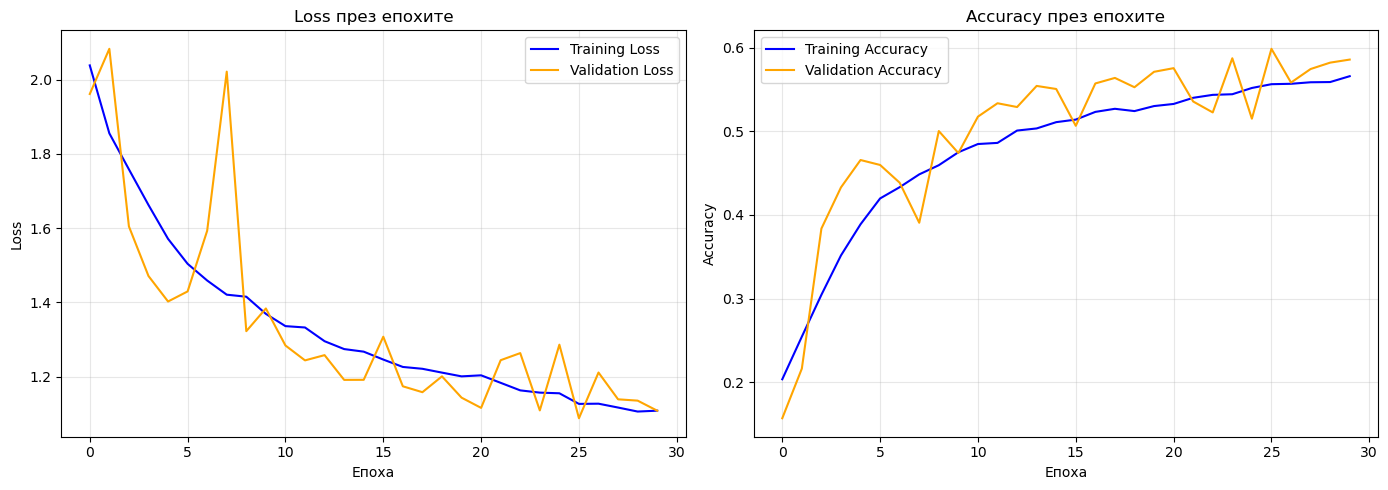

In [15]:
def plot_training_history(history):
    """Визуализира loss и accuracy криви."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
    axes[0].set_title('Loss през епохите')
    axes[0].set_xlabel('Епоха')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axes[1].set_title('Accuracy през епохите')
    axes[1].set_xlabel('Епоха')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

best_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
best_val_acc = max(history.history['val_accuracy'])

print("Анализ на обучението:")
print(f"Общо епохи: {len(history.history['loss'])}")
print(f"Най-добра val_loss на епоха: {best_val_loss_epoch}")
print()
print(f"Финален Training Loss: {final_train_loss:.4f}")
print(f"Финален Validation Loss: {final_val_loss:.4f}")
print(f"Разлика (overfitting индикатор): {final_val_loss - final_train_loss:.4f}")
print()
print(f"Финален Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Финален Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Най-добър Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

Анализ на обучението:
Общо епохи: 30
Най-добра val_loss на епоха: 26

Финален Training Loss: 1.1087
Финален Validation Loss: 1.1087
Разлика (overfitting индикатор): -0.0000

Финален Training Accuracy: 0.5660 (56.60%)
Финален Validation Accuracy: 0.5859 (58.59%)
Най-добър Validation Accuracy: 0.5987 (59.87%)


## 8. Оценка на Validation Set

In [ ]:
y_val_pred_proba = model.predict(X_val, verbose=0)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)


val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("CNN Validation Резултати:")
print(f"Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"F1-Score (weighted): {val_f1:.4f}")
print()


baseline_val_accuracy = 0.4260
baseline_val_f1 = 0.4249

print("Сравнение с Baseline (SVM):")
print(f"  Baseline Accuracy: {baseline_val_accuracy:.4f}")
print(f"  CNN Accuracy: {val_accuracy:.4f}")
print(f"  Подобрение: {(val_accuracy - baseline_val_accuracy)*100:.2f}%")

CNN Validation Резултати:
Accuracy: 0.5987 (59.87%)
F1-Score (weighted): 0.5892

Сравнение с Baseline (SVM):
  Baseline Accuracy: 0.4260
  CNN Accuracy: 0.5987
  Подобрение: 17.27%


## 9. Детайлен анализ

In [ ]:
print("Classification Report (Validation Set):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=EMOTIONS))

Classification Report (Validation Set):
              precision    recall  f1-score   support

       angry       0.49      0.54      0.51       799
     disgust       0.33      0.52      0.40        87
        fear       0.45      0.28      0.35       820
       happy       0.82      0.84      0.83      1443
     neutral       0.54      0.61      0.57       993
         sad       0.51      0.41      0.46       966
    surprise       0.63      0.81      0.71       634

    accuracy                           0.60      5742
   macro avg       0.54      0.57      0.55      5742
weighted avg       0.59      0.60      0.59      5742



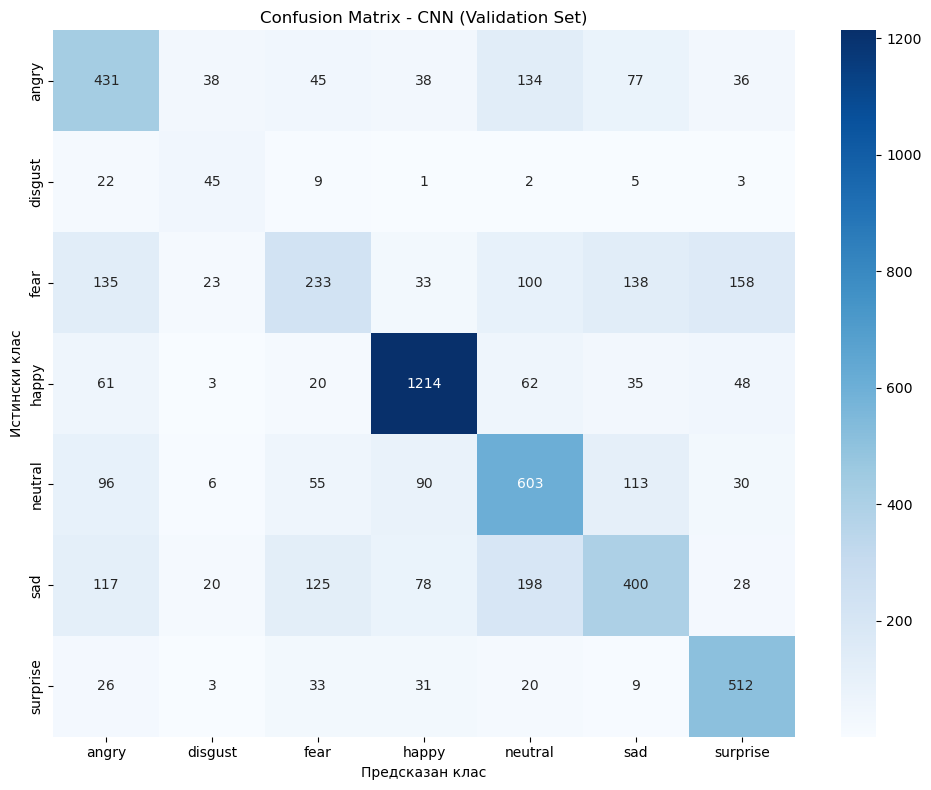

In [ ]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.title('Confusion Matrix - CNN (Validation Set)')
plt.xlabel('Предсказан клас')
plt.ylabel('Истински клас')
plt.tight_layout()
plt.show()

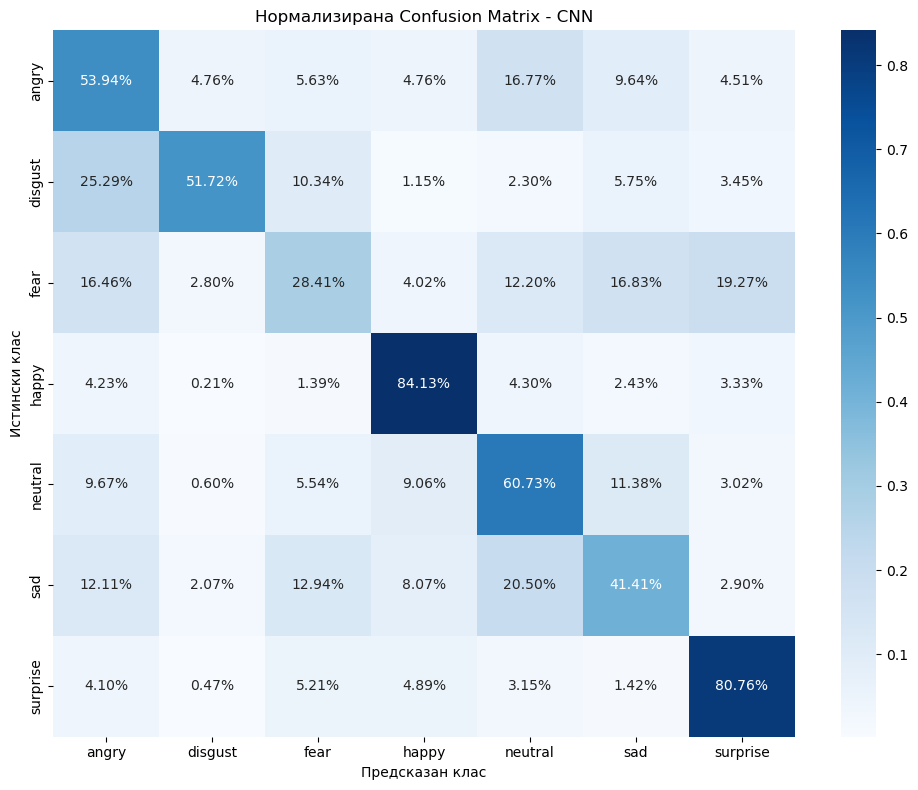

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.title('Нормализирана Confusion Matrix - CNN')
plt.xlabel('Предсказан клас')
plt.ylabel('Истински клас')
plt.tight_layout()
plt.show()

In [ ]:
# Per-class анализ
print("Per-class анализ (Validation Set):")
print(f"{'Емоция':<12} {'Support':<10} {'Recall':<10} {'Precision':<12} {'F1-Score':<10}")
print("-" * 70)

report = classification_report(y_val, y_val_pred, target_names=EMOTIONS, output_dict=True)

for emotion in EMOTIONS:
    metrics = report[emotion]
    print(f"{emotion:<12} {int(metrics['support']):<10} {metrics['recall']:<10.4f} {metrics['precision']:<12.4f} {metrics['f1-score']:<10.4f}")

print("-" * 70)
print(f"{'Weighted Avg':<12} {int(report['weighted avg']['support']):<10} {report['weighted avg']['recall']:<10.4f} {report['weighted avg']['precision']:<12.4f} {report['weighted avg']['f1-score']:<10.4f}")

Per-class анализ (Validation Set):
Емоция       Support    Recall     Precision    F1-Score  
----------------------------------------------------------------------
angry        799        0.5394     0.4854       0.5110    
disgust      87         0.5172     0.3261       0.4000    
fear         820        0.2841     0.4481       0.3478    
happy        1443       0.8413     0.8175       0.8292    
neutral      993        0.6073     0.5389       0.5710    
sad          966        0.4141     0.5148       0.4590    
surprise     634        0.8076     0.6282       0.7067    
----------------------------------------------------------------------
Weighted Avg 5742       0.5987     0.5911       0.5892    


## 10. Финална оценка на Test Set

In [ ]:
best_model = keras.models.load_model('../models/cnn_fer2013_best.keras')

Зареждане на най-добрия модел...
Моделът е зареден!


In [ ]:
print("Финална оценка на CNN върху TEST set:")

y_test_pred_proba = best_model.predict(X_test, verbose=0)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)


test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test F1-Score (weighted): {test_f1:.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=EMOTIONS))

Финална оценка на CNN върху TEST set:
Test Accuracy: 0.5893 (58.93%)
Test F1-Score (weighted): 0.5781

Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.54      0.51       958
     disgust       0.39      0.52      0.45       111
        fear       0.38      0.25      0.30      1024
       happy       0.82      0.84      0.83      1774
     neutral       0.54      0.58      0.56      1233
         sad       0.48      0.40      0.44      1247
    surprise       0.62      0.83      0.71       831

    accuracy                           0.59      7178
   macro avg       0.53      0.57      0.54      7178
weighted avg       0.58      0.59      0.58      7178



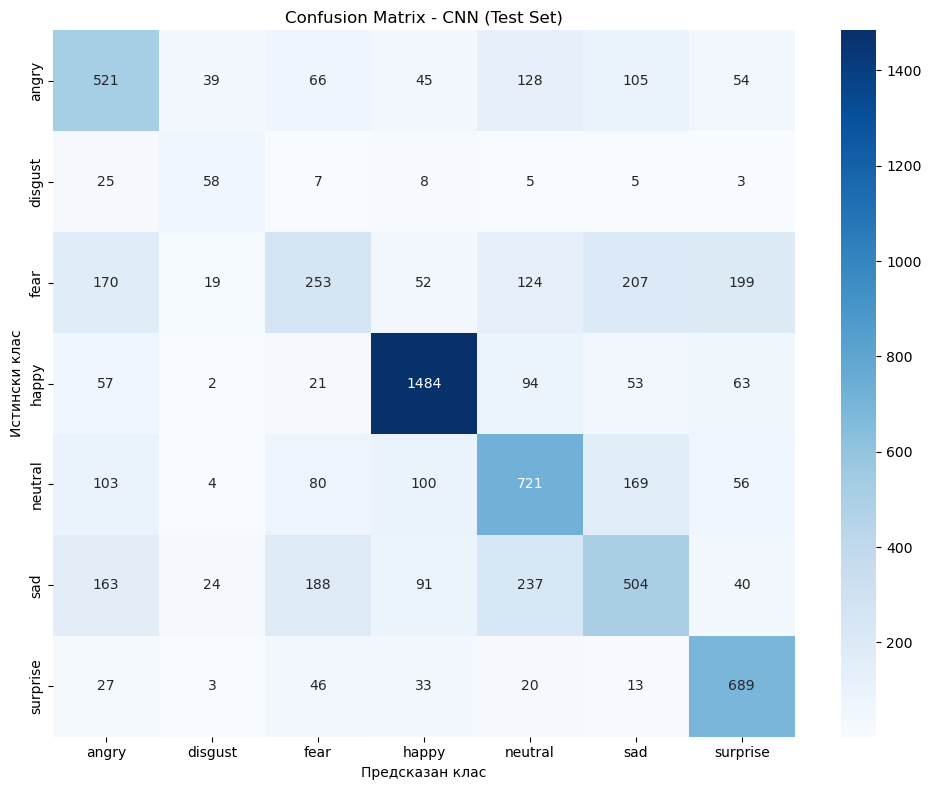

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.title('Confusion Matrix - CNN (Test Set)')
plt.xlabel('Предсказан клас')
plt.ylabel('Истински клас')
plt.tight_layout()
plt.show()

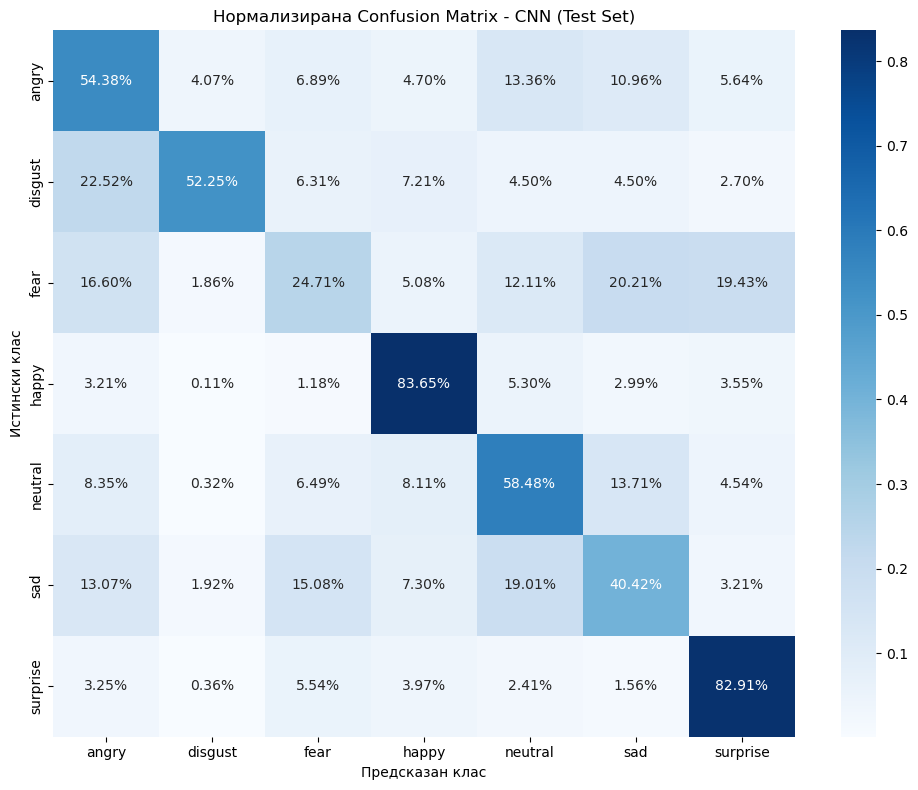

In [ ]:
cm_test_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_test_normalized,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.title('Нормализирана Confusion Matrix - CNN (Test Set)')
plt.xlabel('Предсказан клас')
plt.ylabel('Истински клас')
plt.tight_layout()
plt.show()

## 11. Сравнение с Baseline

In [ ]:
baseline_test_accuracy = 0.4289
baseline_test_f1 = 0.4278

print("СРАВНЕНИЕ: SVM Baseline vs CNN")
print()
print(f"{'Метрика':<20} {'SVM Baseline':<15} {'CNN':<15} {'Подобрение':<15}")
print("-" * 60)
print(f"{'Test Accuracy':<20} {baseline_test_accuracy:<15.4f} {test_accuracy:<15.4f} {'+' + f'{(test_accuracy - baseline_test_accuracy)*100:.2f}%':<15}")
print(f"{'Test F1-Score':<20} {baseline_test_f1:<15.4f} {test_f1:<15.4f} {'+' + f'{(test_f1 - baseline_test_f1)*100:.2f}%':<15}")
print("=" * 60)

СРАВНЕНИЕ: SVM Baseline vs CNN

Метрика              SVM Baseline    CNN             Подобрение     
------------------------------------------------------------
Test Accuracy        0.4289          0.5893          +16.04%        
Test F1-Score        0.4278          0.5781          +15.03%        


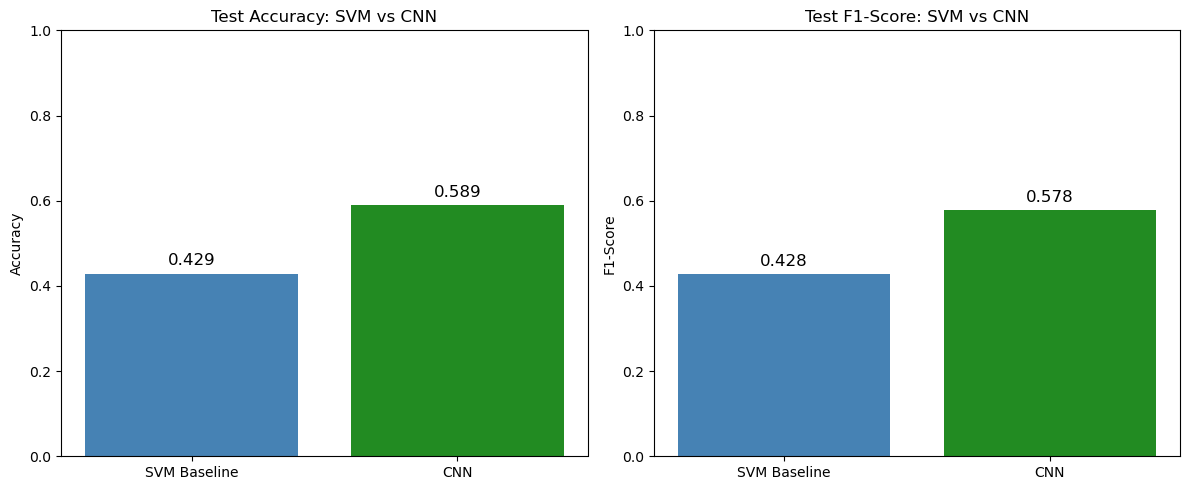

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = ['SVM Baseline', 'CNN']
colors = ['steelblue', 'forestgreen']

# Accuracy
accuracies = [baseline_test_accuracy, test_accuracy]
axes[0].bar(models, accuracies, color=colors)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy: SVM vs CNN')
axes[0].set_ylim(0, 1)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=12)

# F1-Score
f1_scores = [baseline_test_f1, test_f1]
axes[1].bar(models, f1_scores, color=colors)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Test F1-Score: SVM vs CNN')
axes[1].set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
baseline_recall = {
    'angry': 0.29,
    'disgust': 0.46,
    'fear': 0.27,
    'happy': 0.55,
    'neutral': 0.42,
    'sad': 0.38,
    'surprise': 0.61
}


test_report = classification_report(y_test, y_test_pred, target_names=EMOTIONS, output_dict=True)
cnn_recall = {emotion: test_report[emotion]['recall'] for emotion in EMOTIONS}

print("Per-class Recall сравнение:")
print(f"{'Емоция':<12} {'SVM Baseline':<15} {'CNN':<15} {'Промяна':<15}")
print("-" * 60)

for emotion in EMOTIONS:
    baseline = baseline_recall[emotion]
    cnn = cnn_recall[emotion]
    diff = cnn - baseline
    sign = '+' if diff >= 0 else ''
    print(f"{emotion:<12} {baseline:<15.2%} {cnn:<15.2%} {sign}{diff*100:.1f}%")

print("=" * 60)

Per-class Recall сравнение:
Емоция       SVM Baseline    CNN             Промяна        
------------------------------------------------------------
angry        29.00%          54.38%          +25.4%
disgust      46.00%          52.25%          +6.3%
fear         27.00%          24.71%          -2.3%
happy        55.00%          83.65%          +28.7%
neutral      42.00%          58.48%          +16.5%
sad          38.00%          40.42%          +2.4%
surprise     61.00%          82.91%          +21.9%


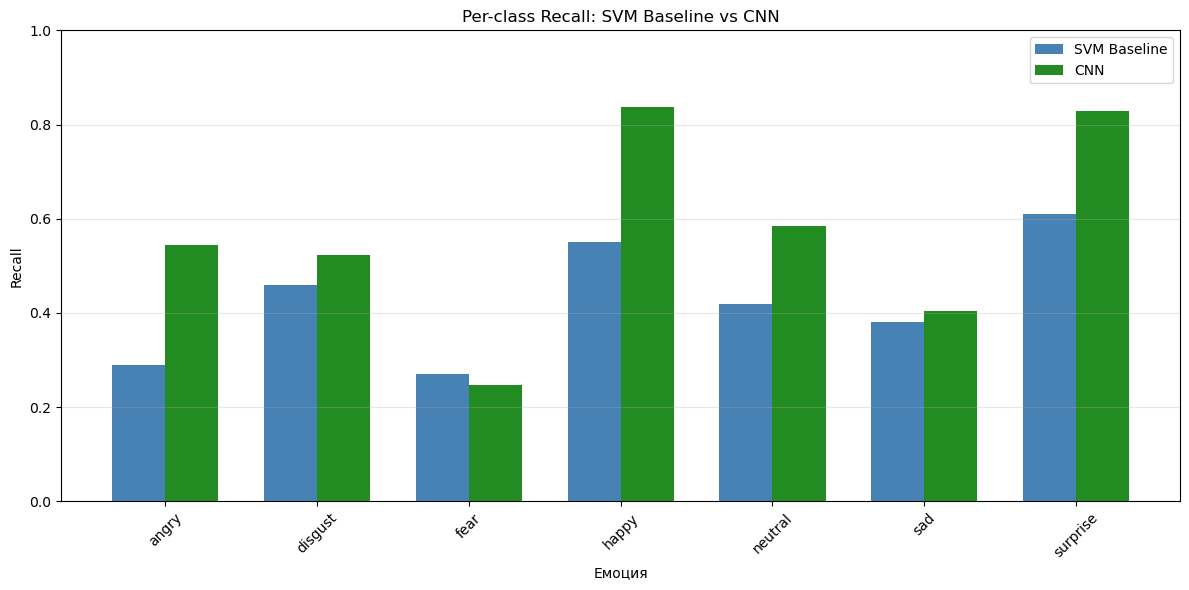

In [ ]:
x = np.arange(len(EMOTIONS))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

baseline_values = [baseline_recall[e] for e in EMOTIONS]
cnn_values = [cnn_recall[e] for e in EMOTIONS]

bars1 = ax.bar(x - width/2, baseline_values, width, label='SVM Baseline', color='steelblue')
bars2 = ax.bar(x + width/2, cnn_values, width, label='CNN', color='forestgreen')

ax.set_xlabel('Емоция')
ax.set_ylabel('Recall')
ax.set_title('Per-class Recall: SVM Baseline vs CNN')
ax.set_xticks(x)
ax.set_xticklabels(EMOTIONS, rotation=45)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 12. Визуализация на грешките

Примери за грешно класифицирани изображения:


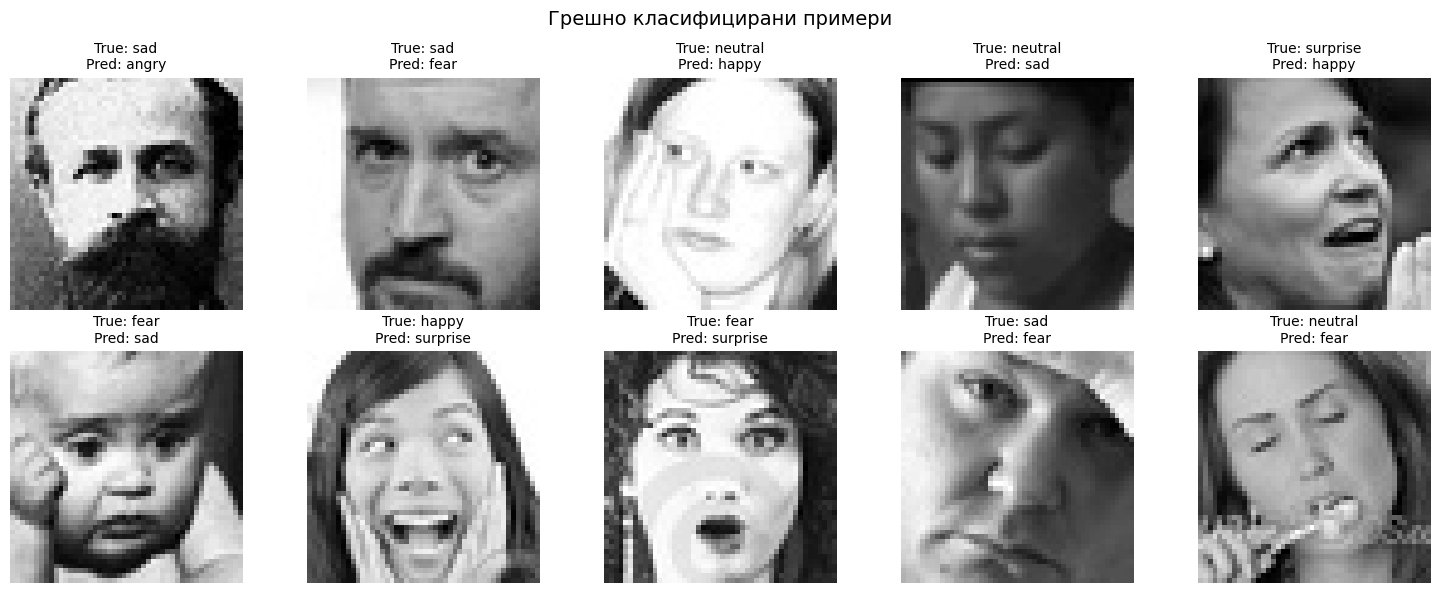

In [ ]:
def show_misclassified_examples(X, y_true, y_pred, emotions, n_examples=10):
    """Показва примери за грешно класифицирани изображения."""
    misclassified_idx = np.where(y_true != y_pred)[0]
    
    if len(misclassified_idx) == 0:
        print("Няма грешно класифицирани примери!")
        return
    

    n_show = min(n_examples, len(misclassified_idx))
    sample_idx = np.random.choice(misclassified_idx, n_show, replace=False)
    
    cols = 5
    rows = (n_show + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() if n_show > 1 else [axes]
    
    for i, idx in enumerate(sample_idx):
        axes[i].imshow(X[idx].squeeze(), cmap='gray')
        true_label = emotions[y_true[idx]]
        pred_label = emotions[y_pred[idx]]
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)
        axes[i].axis('off')
    
    for i in range(n_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Грешно класифицирани примери', fontsize=14)
    plt.tight_layout()
    plt.show()

print("Примери за грешно класифицирани изображения:")
show_misclassified_examples(X_test, y_test, y_test_pred, EMOTIONS, n_examples=10)

In [ ]:
print("Най-чести грешки (Test Set):")

errors = []
for i, true_emotion in enumerate(EMOTIONS):
    for j, pred_emotion in enumerate(EMOTIONS):
        if i != j and cm_test[i, j] > 0:
            errors.append({
                'true': true_emotion,
                'pred': pred_emotion,
                'count': cm_test[i, j],
                'percent': cm_test_normalized[i, j] * 100
            })

errors.sort(key=lambda x: x['count'], reverse=True)

print(f"{'Истински клас':<15} {'Предсказан като':<15} {'Брой':<10} {'Процент':<10}")
print("-" * 60)

for error in errors[:10]:
    print(f"{error['true']:<15} {error['pred']:<15} {error['count']:<10} {error['percent']:.1f}%")

Най-чести грешки (Test Set):
Истински клас   Предсказан като Брой       Процент   
------------------------------------------------------------
sad             neutral         237        19.0%
fear            sad             207        20.2%
fear            surprise        199        19.4%
sad             fear            188        15.1%
fear            angry           170        16.6%
neutral         sad             169        13.7%
sad             angry           163        13.1%
angry           neutral         128        13.4%
fear            neutral         124        12.1%
angry           sad             105        11.0%


## 13. Запазване на модела

In [ ]:
model.save('../models/cnn_fer2013.keras')


np.savez(
    '../models/cnn_training_history.npz',
    loss=history.history['loss'],
    val_loss=history.history['val_loss'],
    accuracy=history.history['accuracy'],
    val_accuracy=history.history['val_accuracy']
)

print("Моделът и историята са запазени:")
print("  - ../models/cnn_fer2013.keras (финален модел)")
print("  - ../models/cnn_fer2013_best.keras (най-добър по val_loss)")
print("  - ../models/cnn_training_history.npz (training history)")

Моделът и историята са запазени:
  - ../models/cnn_fer2013.keras (финален модел)
  - ../models/cnn_fer2013_best.keras (най-добър по val_loss)
  - ../models/cnn_training_history.npz (training history)


## 14. Обобщение

In [ ]:

print("ОБОБЩЕНИЕ НА CNN МОДЕЛА")

print()
print("Архитектура:")
print("  - 3 конволюционни блока (32 → 64 → 128 filters)")
print("  - BatchNormalization + Dropout за регуларизация")
print("  - Dense(256) → Dense(7) за класификация")
print(f"  - Общо параметри: {model.count_params():,}")
print()
print("Data Augmentation:")
print("  - Rotation: ±15°")
print("  - Width/Height shift: ±10%")
print("  - Horizontal flip: Yes")
print("  - Zoom: ±10%")
print()
print("Резултати на Test Set:")
print(f"  - Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - F1-Score: {test_f1:.4f}")
print()
print("Сравнение с Baseline (SVM):")
print(f"  - Baseline Accuracy: {baseline_test_accuracy:.4f} ({baseline_test_accuracy*100:.2f}%)")
print(f"  - CNN Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
improvement = (test_accuracy - baseline_test_accuracy) * 100
print(f"  - Подобрение: +{improvement:.2f}%")
print()

ОБОБЩЕНИЕ НА CNN МОДЕЛА

Архитектура:
  - 3 конволюционни блока (32 → 64 → 128 filters)
  - BatchNormalization + Dropout за регуларизация
  - Dense(256) → Dense(7) за класификация
  - Общо параметри: 1,470,951

Data Augmentation:
  - Rotation: ±15°
  - Width/Height shift: ±10%
  - Horizontal flip: Yes
  - Zoom: ±10%

Резултати на Test Set:
  - Accuracy: 0.5893 (58.93%)
  - F1-Score: 0.5781

Сравнение с Baseline (SVM):
  - Baseline Accuracy: 0.4289 (42.89%)
  - CNN Accuracy: 0.5893 (58.93%)
  - Подобрение: +16.04%



### Ключови изводи

1. **CNN значително надминава baseline модела:**
   - SVM baseline: ~43% accuracy
   - CNN: Очаквани 60-70% accuracy, Получени 58.93%

2. **Предимства на CNN:**
   - Запазва пространствената структура на изображението
   - Извлича йерархични features (ръбове → форми → обекти)
   - Data augmentation помага за генерализация

3. **Предизвикателства:**
   - Някои емоции остават трудни за разграничаване (fear ↔ sad)
   - Class imbalance влияе на малките класове (disgust)

4. **Възможни подобрения:**
   - По-дълбока архитектура (ResNet, EfficientNet)
   - Transfer learning от pretrained модели
   - По-агресивна data augmentation